- 친밀도 및 적절성 데이터를 이용한 만족도 예측
- 사용 데이터 : drinking_water.csv
- 사용모델 : 지금까지 배운 모든 모델 활용
- 데이터 전처리부터 ~ 상관관계 검증 등 모든 사전 처리 진행
- 특성공학 및 스케일링 등 모든 처리 적용
- 모델별로 성능 평가 및 해석
    - 성능 평가는 특성공학/스케일링/하이퍼 파라미터 적용 전/후 모두 훈련 평가 후 분석
- 최종 모델 선정
- 최종 모델로 예측 및 평가
- 조별로 자유롭게 진행
- 제출 : 0조_본인이름_만족도예측.ipynb

#### 라이브러리 정의

In [1]:
### 라이브러리 정의
# - 데이터를 읽기 위한 라이브러리
import pandas as pd

# - 시각화 라이브러리
import matplotlib.pyplot as plt

# - 히트맵 라이브러리
import seaborn as sns

# - 수치 계산 라이브러리
import numpy as np

# - 데이터 가공 라이브러리
from sklearn.model_selection import train_test_split

### KNN 회귀모델 라이브러리 정의하기
from sklearn.neighbors import KNeighborsRegressor

# - 선형회귀모델 라이브러리
from sklearn.linear_model import LinearRegression

# - 릿지 모델 라이브러리
from sklearn.linear_model import Ridge

# - 라쏘 모델 라이브러리
from sklearn.linear_model import Lasso

# - 앙상블 모델
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor

# - 변환기 모델(클래스) 라이브러리 정의
from sklearn.preprocessing import PolynomialFeatures

# - 데이터 스케일링 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# 하이퍼파라메터 튜닝 모델(클래스) 정의하기
from sklearn.model_selection import GridSearchCV

### 평가 라이브러리 정의
# 평균절대오차(MAE)
from sklearn.metrics import mean_absolute_error
# 평균제곱오차(MSE)
from sklearn.metrics import mean_squared_error
# 결정계수(R2-score)
from sklearn.metrics import r2_score

# - 상관관계 검증 라이브러리
from scipy.stats import spearmanr # 스피어만
from scipy.stats import pearsonr # 피어슨

### 경고(오류는 아님) 메시지 없애기
# - 사이킷런 버전에 따라 오류가 아니니 안내(경고)메시지가 자주 나타남
# - 안내(경고) 메시지 없이 실행할 수 있도록 처리
from sklearn import set_config
set_config(display="text")

# - 한글처리
plt.rc("font", family="Malgun Gothic")

# - 마이너스 기호 깨짐 처리
plt.rcParams["axes.unicode_minus"] = False

#### 파일 읽기

In [2]:
file_path = "./data/04_(실습)_회귀모델_drinking_water.csv"
df_org = pd.read_csv(file_path)

df_org

,친밀도,적절성,만족도
0,3,4,3
1,3,3,2
2,4,4,4
3,2,2,2
4,2,2,2
...,...,...,...
259,3,4,4
260,3,4,3
261,4,4,4
262,4,4,4


In [3]:
### 데이터 정보 확인
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   친밀도     264 non-null    int64
 1   적절성     264 non-null    int64
 2   만족도     264 non-null    int64
dtypes: int64(3)
memory usage: 6.3 KB


In [4]:
### 기초 통계 확인
df_org.describe()

,친밀도,적절성,만족도
count,264.000000,264.000000,264.000000
mean,2.928030,3.132576,3.094697
std,0.970345,0.859657,0.828744
min,1.000000,1.000000,1.000000
25%,2.000000,3.000000,3.000000
50%,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000


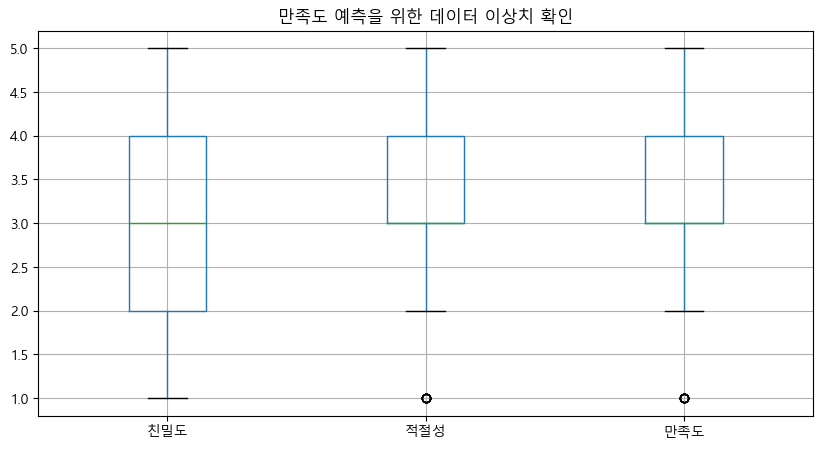

In [5]:
### 박스플룻으로 이상치를 시각적으로 확인해보기
plt.figure(figsize=(10, 5))
plt.title("만족도 예측을 위한 데이터 이상치 확인")

# 박스플롯 그리기
df_org.boxplot()
plt.show()

In [6]:
# 상관관계표 : corr()함수 사용(데이터프레임에 포함되어 있음)
correlation_matrix = df_org.corr()
correlation_matrix

,친밀도,적절성,만족도
친밀도,1.000000,0.499209,0.467145
적절성,0.499209,1.000000,0.766853
만족도,0.467145,0.766853,1.000000


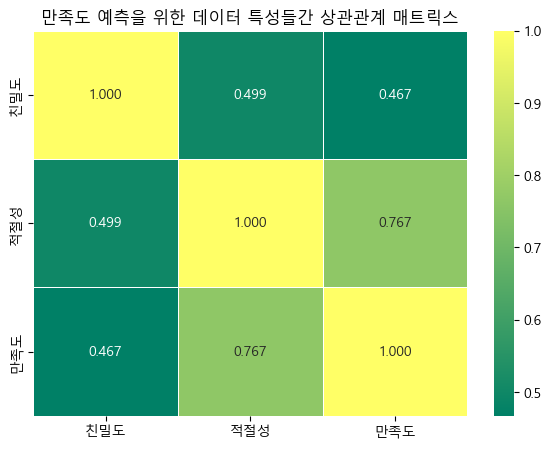

In [7]:
# 상관관계 매트릭스 히트맵 확인
plt.figure(figsize=(7,5))
plt.title("만족도 예측을 위한 데이터 특성들간 상관관계 매트릭스")
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", 
            cmap="summer", linewidths=0.5)
plt.show()

# 해석?
# 모든 관계에서 우상향 비례, 만족도-적절성 관계는 다른 관계에 비해 관계성이 좋음

#### 상관관계 검증(검정) 하기 -> 유의미성(p-value) 확인

In [8]:
### 특성분리
# 독립변수 : 친밀도, 적절성
# 종속변수 : 만족도

x = df_org[["친밀도", "적절성"]]
x

,친밀도,적절성
0,3,4
1,3,3
2,4,4
3,2,2
4,2,2
...,...,...
259,3,4
260,3,4
261,4,4
262,4,4


In [9]:
y = df_org["만족도"]
y

0      3
1      2
2      4
3      2
4      2
      ..
259    4
260    3
261    4
262    4
263    3
Name: 만족도, Length: 264, dtype: int64

In [10]:
# 독립변수의 특성 이름 추출하기
x_columns_nm = x.columns
x_columns_nm

Index(['친밀도', '적절성'], dtype='object')

In [11]:
# 독립변수 "면적"과 종속변수 "주택가격"과의 상관관계 검증(유의미성 확인)
x[x_columns_nm[0]]
spearmanr(x[x_columns_nm[0]], y)

SignificanceResult(statistic=0.5012006658643047, pvalue=3.383407076477574e-18)

In [12]:
# 모든 독립변수 각각에 대하여 종속변수와의 상관관계 유의미성을 확인
for col in x_columns_nm :
    s, p = spearmanr(x[col], y)
    p_msg = "유의미 하지 않음"
    
    if p < 0.05 : 
        p_msg = "유의미 함"
        
    msg = f"""
        독립변수({col})와 종속변수(주택가격)의 상관관계 계수는 {s:.3f}이고, 
        pvalue의 값은 {p}임. 따라서 p-value < 0.05에 대하여 {p_msg}
    """
    print(msg)


        독립변수(친밀도)와 종속변수(주택가격)의 상관관계 계수는 0.501이고, 
        pvalue의 값은 3.383407076477574e-18임. 따라서 p-value < 0.05에 대하여 유의미 함
    

        독립변수(적절성)와 종속변수(주택가격)의 상관관계 계수는 0.749이고, 
        pvalue의 값은 1.1877299204509877e-48임. 따라서 p-value < 0.05에 대하여 유의미 함
    


#### 훈련 : 검증 데이터 분류 7.5 : 2.5

In [13]:
### 훈련 : 검증 = 7.5 : 2.5 비율로 분류
# - 사용 변수명 
# - 훈련 독립변수 / 종속변수 = x_train / y_train
# - 테스트 독립변수 / 종속변수 = x_test / y_test

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42
)

print(x_train.shape, y_train.shape)
print(x_test.shape,  y_test.shape)

(198, 2) (198,)
(66, 2) (66,)


#### 스케일링 처리(전처리)
- 해당 데이터에서는 모든 컬럼의 데이터 범위가 1 ~ 5 사이로 확인이 됨
- 스케일링 처리를 하지 않아도 되는 데이터로 확인 되었으나
- 스터디 목적으로 진행 하였음

In [14]:
### Standard 스케일링으로 처리
# - 각 독립변수 명 : x_train_scaled, x_test_scaled

ss = StandardScaler()
ss.fit(x_train)
x_train_scaled = ss.transform(x_train) # 훈련데이터
x_test_scaled = ss.transform(x_test) # 검증 데이터

print(x_train_scaled.shape, y_train.shape)
print(x_test_scaled.shape,  y_test.shape)

(198, 2) (198,)
(66, 2) (66,)


In [15]:
# 스케일 처리 확인
x_train_scaled

array([[ 0.08553826, -1.32003581],
       [ 1.14407426,  0.99294729],
       [ 0.08553826, -1.32003581],
       [ 1.14407426,  0.99294729],
       [ 0.08553826, -0.16354426],
       [ 0.08553826, -0.16354426],
       [ 0.08553826, -0.16354426],
       [ 0.08553826, -1.32003581],
       [ 1.14407426,  0.99294729],
       [ 0.08553826, -0.16354426],
       [-2.03153373, -1.32003581],
       [ 1.14407426,  0.99294729],
       [ 0.08553826,  0.99294729],
       [-2.03153373, -0.16354426],
       [ 1.14407426, -0.16354426],
       [ 0.08553826,  0.99294729],
       [ 0.08553826, -0.16354426],
       [ 0.08553826, -0.16354426],
       [ 1.14407426,  0.99294729],
       [ 1.14407426,  0.99294729],
       [-0.97299773, -0.16354426],
       [ 2.20261026,  2.14943884],
       [ 0.08553826, -0.16354426],
       [-2.03153373,  0.99294729],
       [ 0.08553826, -0.16354426],
       [ 0.08553826, -0.16354426],
       [-2.03153373, -0.16354426],
       [ 0.08553826, -1.32003581],
       [ 1.14407426,

#### 모델 훈련하기

In [16]:
import Model_Class as model

# - 각 독립변수 명 : x_train_scaled, x_test_scaled
# - 테스트 독립변수 / 종속변수 = x_test / y_test

In [17]:
knn = model.KNNModel()
knn_total = knn.knn_total_model(x_train_scaled, y_train, x_test_scaled, y_test)
knn_total

 -** KNN 회귀 모델 **- 
훈련 결정계수 : 0.6105, 테스트 결정계수 : 0.5705, 과적합여부 : 0.0400
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.3354, 평균제곱오차(MSE) : 0.2683, R2_Score : 0.6105
테스트 데이터 평가
평균절대오차(MAE) : 0.3758, 평균제곱오차(MSE) : 0.2800, R2_Score : 0.5705
 
 -** KNN + 표준화 스케일링 **- 
훈련 결정계수 : 0.6105, 테스트 결정계수 : 0.5705, 과적합여부 : 0.0400
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.3354, 평균제곱오차(MSE) : 0.2683, R2_Score : 0.6105
테스트 데이터 평가
평균절대오차(MAE) : 0.3758, 평균제곱오차(MSE) : 0.2800, R2_Score : 0.5705
 
 -** KNN + MinMax 스케일링 **- 
훈련 결정계수 : 0.6284, 테스트 결정계수 : 0.5910, 과적합여부 : 0.0374
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.3283, 평균제곱오차(MSE) : 0.2560, R2_Score : 0.6284
테스트 데이터 평가
평균절대오차(MAE) : 0.3636, 평균제곱오차(MSE) : 0.2667, R2_Score : 0.5910
 
 -** KNN + Robust 스케일링 **- 
훈련 결정계수 : 0.6217, 테스트 결정계수 : 0.5975, 과적합여부 : 0.0242
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.3313, 평균제곱오차(MSE) : 0.2606, R2_Score : 0.6217
테스트 데이터 평가
평균절대오차(MAE) : 0.3727, 평균제곱오차(MSE) : 0.2624, R2_Score : 0.5975
 
-** 폴리노미얼 2

In [18]:
knn.get_knn_results()

,model_nm,train_mae,train_mse,train_r2,test_mae,test_mse,test_r2,train_r2-val_r2
0,KNNModel,0.335354,0.268283,0.610525,0.375758,0.280000,0.570535,0.039990
1,KNNStandardModel,0.335354,0.268283,0.610525,0.375758,0.280000,0.570535,0.039990
2,KNNMinMaxModel,0.328283,0.255960,0.628415,0.363636,0.266667,0.590986,0.037430
3,KNNRobustModel,0.331313,0.260606,0.621670,0.372727,0.262424,0.597493,0.024177
4,KNNPolyModel2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,KNNPolyModel3,0.333333,0.270303,0.607593,0.381818,0.283636,0.564958,0.042635
6,KNNPolyModel4,0.345455,0.290101,0.578851,0.369697,0.300606,0.538930,0.039922
7,KNNPolyStandardModel2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,KNNPolyStandardModel3,0.327273,0.248485,0.639267,0.372727,0.268485,0.588197,0.051070
9,KNNPolyStandardModel4,0.327273,0.248485,0.639267,0.372727,0.268485,0.588197,0.051070


In [19]:
lr = model.LinearModel()
linear_total = lr.linear_total_model(x_train_scaled, y_train, x_test_scaled, y_test)
linear_total

 -** 선형 회귀 모델 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 선형 + 표준화 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 선형 + MinMax 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 선형 + Robust 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 2 차 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 3 차 모델 **- 
3 차원 모델이 생성되었습니다.
훈련 결정계수 : 0.6459, 테스트 결정계수 : 0.6184, 과적합여부 : 0.0275
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.3613, 평균제곱오차(MSE) : 0.2439, R2_Score : 0.6459
테스트 데이터 평가
평균절대오차(MAE) : 0.3789, 평균제곱오차(MSE) : 0.2488, R2_Score : 0.6184
 
-** 폴리노미얼 4 차 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 2 차 + 표준화 스케일링 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 3 차 + 표준화 스케일링 모델 **- 
3 차원 모델이 생성되었습니다.
훈련 결정계수 : 0.6459, 테스트 결정계수 : 0.6184, 과적합여부 : 0.0275
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.3613, 평균제곱오차(MSE) : 0.2439, R2_Score : 0.6459
테스트 데이터 평가
평균절대오차(MAE) : 0.3789, 평균제곱오차(MSE) : 0.2488, R2_Score : 0.6184
 
 -** 폴리노미얼 4 차 + 표준화 스케일링 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사

In [20]:
lr.get_linear_results()

,model_nm,train_mae,train_mse,train_r2,test_mae,test_mse,test_r2,train_r2-val_r2
0,LinearModel,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LinearStandardModel,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LinearMinMaxModel,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LinearRobustModel,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LinearPolyModel2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LinearPolyModel3,0.36128,0.243934,0.645874,0.378931,0.248821,0.618357,0.027517
6,LinearPolyModel4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LinearPolyStandardModel2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,LinearPolyStandardModel3,0.36128,0.243934,0.645874,0.378931,0.248821,0.618357,0.027517
9,LinearPolyStandardModel4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
rg = model.RidgeModel()
ridge_total = rg.ridge_total_model(x_train_scaled, y_train, x_test_scaled, y_test)
ridge_total

 -** 릿지 모델 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 릿지 + 표준화 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 릿지 + MinMax 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 릿지 + Robust 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 2 차 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 3 차 모델 **- 
3 차원 모델이 생성되었습니다.
훈련 결정계수 : 0.6458, 테스트 결정계수 : 0.6213, 과적합여부 : 0.0246
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.3609, 평균제곱오차(MSE) : 0.2440, R2_Score : 0.6458
테스트 데이터 평가
평균절대오차(MAE) : 0.3777, 평균제곱오차(MSE) : 0.2469, R2_Score : 0.6213
 
-** 폴리노미얼 4 차 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 2 차 + 표준화 스케일링 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 3 차 + 표준화 스케일링 모델 **- 
3 차원 모델이 생성되었습니다.
훈련 결정계수 : 0.6457, 테스트 결정계수 : 0.6234, 과적합여부 : 0.0223
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.3601, 평균제곱오차(MSE) : 0.2440, R2_Score : 0.6457
테스트 데이터 평가
평균절대오차(MAE) : 0.3748, 평균제곱오차(MSE) : 0.2455, R2_Score : 0.6234
 
 -** 폴리노미얼 4 차 + 표준화 스케일링 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 

In [22]:
rg.get_ridge_results()

,model_nm,train_mae,train_mse,train_r2,test_mae,test_mse,test_r2,train_r2-val_r2
0,RidgeModel,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RidgeStandardModel,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RidgeMinMaxModel,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RidgeRobustModel,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RidgePolyModel2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,RidgePolyModel3,0.360938,0.243976,0.645812,0.377676,0.246933,0.621253,0.024559
6,RidgePolyModel4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,RidgePolyStandardModel2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,RidgePolyStandardModel3,0.360095,0.244039,0.645720,0.374844,0.245513,0.623431,0.022289
9,RidgePolyStandardModel4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
ls = model.LassoModel()
lasso_total = ls.lasso_total_model(x_train_scaled, y_train, x_test_scaled, y_test)
lasso_total

 -** 라쏘 모델 **- 
훈련 결정계수 : 0.0000, 테스트 결정계수 : -0.0376, 과적합여부 : 0.0376
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.5937, 평균제곱오차(MSE) : 0.6888, R2_Score : 0.0000
테스트 데이터 평가
평균절대오차(MAE) : 0.5926, 평균제곱오차(MSE) : 0.6765, R2_Score : -0.0376
 
 -** 라쏘 + 표준화 스케일링 **- 
훈련 결정계수 : 0.0000, 테스트 결정계수 : -0.0376, 과적합여부 : 0.0376
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.5937, 평균제곱오차(MSE) : 0.6888, R2_Score : 0.0000
테스트 데이터 평가
평균절대오차(MAE) : 0.5926, 평균제곱오차(MSE) : 0.6765, R2_Score : -0.0376
 
 -** 라쏘 + MinMax 스케일링 **- 
훈련 결정계수 : 0.0000, 테스트 결정계수 : -0.0376, 과적합여부 : 0.0376
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.5937, 평균제곱오차(MSE) : 0.6888, R2_Score : 0.0000
테스트 데이터 평가
평균절대오차(MAE) : 0.5926, 평균제곱오차(MSE) : 0.6765, R2_Score : -0.0376
 
 -** 라쏘 + Robust 스케일링 **- 
훈련 결정계수 : 0.0000, 테스트 결정계수 : -0.0376, 과적합여부 : 0.0376
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.5937, 평균제곱오차(MSE) : 0.6888, R2_Score : 0.0000
테스트 데이터 평가
평균절대오차(MAE) : 0.5926, 평균제곱오차(MSE) : 0.6765, R2_Score : -0.0376
 
-** 폴리노미얼 

In [24]:
ls.get_lasso_results()

,model_nm,train_mae,train_mse,train_r2,test_mae,test_mse,test_r2,train_r2-val_r2
0,LassoModel,0.593715,0.688833,0.000000,0.592593,0.676487,-0.037598,0.037598
1,LassoStandardModel,0.593715,0.688833,0.000000,0.592593,0.676487,-0.037598,0.037598
2,LassoMinMaxModel,0.593715,0.688833,0.000000,0.592593,0.676487,-0.037598,0.037598
3,LassoRobustModel,0.593715,0.688833,0.000000,0.592593,0.676487,-0.037598,0.037598
4,LassoPolyModel2,0.593715,0.688833,0.000000,0.592593,0.676487,-0.037598,0.037598
5,LassoPolyModel3,0.506708,0.466824,0.322297,0.513263,0.464661,0.287302,0.034996
6,LassoPolyModel4,0.506708,0.466824,0.322297,0.513263,0.464661,0.287302,0.034996
7,LassoPolyStandardModel2,0.593715,0.688833,0.000000,0.592593,0.676487,-0.037598,0.037598
8,LassoPolyStandardModel3,0.593715,0.688833,0.000000,0.592593,0.676487,-0.037598,0.037598
9,LassoPolyStandardModel4,0.593715,0.688833,0.000000,0.592593,0.676487,-0.037598,0.037598


In [25]:
rf = model.RandomForestModel()
randomforest_total = rf.randomforest_total_model(x_train_scaled, y_train, x_test_scaled, y_test)
randomforest_total

 -** 랜덤포레스트 모델 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 랜덤포레스트 + 표준화 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 랜덤포레스트 + MinMax 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 랜덤포레스트 + Robust 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 2 차 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 3 차 모델 **- 
3 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 4 차 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 2 차 + 표준화 스케일링 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 3 차 + 표준화 스케일링 모델 **- 
3 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 4 차 + 표준화 스케일링 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 2 차 + MinMax 스케일링 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 3 차 + MinMax 스케일링 모델 **- 
3 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 4 차 + MinMax 스케일링 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 2 차 + Robust 스케일링 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 3 차 + Robust 스케일링 모델 **- 
3 차원 모델

In [26]:
rf.get_randomforest_results()

,model_nm,train_mae,train_mse,train_r2,test_mae,test_mse,test_r2,train_r2-val_r2
0,RandomForestModel,None,None,None,None,None,None,None
1,RandomForestStandardModel,None,None,None,None,None,None,None
2,RandomForestMinMaxModel,None,None,None,None,None,None,None
3,RandomForestRobustModel,None,None,None,None,None,None,None
4,RandomForestPolyModel2,None,None,None,None,None,None,None
5,RandomForestPolyModel3,None,None,None,None,None,None,None
6,RandomForestPolyModel4,None,None,None,None,None,None,None
7,RandomForestPolyStandardModel2,None,None,None,None,None,None,None
8,RandomForestPolyStandardModel3,None,None,None,None,None,None,None
9,RandomForestPolyStandardModel4,None,None,None,None,None,None,None


In [27]:
et = model.ExtraTreesModel()
extratrees_total = et.extratrees_total_model(x_train_scaled, y_train, x_test_scaled, y_test)
extratrees_total

 -** 엑스트라트리 모델 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 엑스트라트리 + 표준화 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 엑스트라트리 + MinMax 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 엑스트라트리 + Robust 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 2 차 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 3 차 모델 **- 
3 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 4 차 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 2 차 + 표준화 스케일링 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 3 차 + 표준화 스케일링 모델 **- 
3 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 4 차 + 표준화 스케일링 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 2 차 + MinMax 스케일링 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 3 차 + MinMax 스케일링 모델 **- 
3 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 4 차 + MinMax 스케일링 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 2 차 + Robust 스케일링 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 3 차 + Robust 스케일링 모델 **- 
3 차원 모델

In [28]:
et.get_extratrees_results()

,model_nm,train_mae,train_mse,train_r2,test_mae,test_mse,test_r2,train_r2-val_r2
0,ExtraTreesModel,None,None,None,None,None,None,None
1,ExtraTreesStandardModel,None,None,None,None,None,None,None
2,ExtraTreesMinMaxModel,None,None,None,None,None,None,None
3,ExtraTreesRobustModel,None,None,None,None,None,None,None
4,ExtraTreesPolyModel2,None,None,None,None,None,None,None
5,ExtraTreesPolyModel3,None,None,None,None,None,None,None
6,ExtraTreesPolyModel4,None,None,None,None,None,None,None
7,ExtraTreesPolyStandardModel2,None,None,None,None,None,None,None
8,ExtraTreesPolyStandardModel3,None,None,None,None,None,None,None
9,ExtraTreesPolyStandardModel4,None,None,None,None,None,None,None


In [29]:
gd = model.GradientModel()
gradient_total = gd.gradient_total_model(x_train_scaled, y_train, x_test_scaled, y_test)
gradient_total

 -** 그래디언트 모델 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 그래디언트 + 표준화 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 그래디언트 + MinMax 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 그래디언트 + Robust 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 2 차 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 3 차 모델 **- 
3 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 4 차 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 2 차 + 표준화 스케일링 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 3 차 + 표준화 스케일링 모델 **- 
3 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 4 차 + 표준화 스케일링 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 2 차 + MinMax 스케일링 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 3 차 + MinMax 스케일링 모델 **- 
3 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 4 차 + MinMax 스케일링 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 2 차 + Robust 스케일링 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 3 차 + Robust 스케일링 모델 **- 
3 차원 모델이 생성

In [30]:
gd.get_gradient_results()

,model_nm,train_mae,train_mse,train_r2,test_mae,test_mse,test_r2,train_r2-val_r2
0,GradientModel,None,None,None,None,None,None,None
1,GradientStandardModel,None,None,None,None,None,None,None
2,GradientMinMaxModel,None,None,None,None,None,None,None
3,GradientRobustModel,None,None,None,None,None,None,None
4,GradientPolyModel2,None,None,None,None,None,None,None
5,GradientPolyModel3,None,None,None,None,None,None,None
6,GradientPolyModel4,None,None,None,None,None,None,None
7,GradientPolyStandardModel2,None,None,None,None,None,None,None
8,GradientPolyStandardModel3,None,None,None,None,None,None,None
9,GradientPolyStandardModel4,None,None,None,None,None,None,None


In [31]:
hgd = model.HistGradientModel()
histgradient_total = hgd.histgradient_total_model(x_train_scaled, y_train, x_test_scaled, y_test)
histgradient_total

 -** 히스트그래디언트 모델 **- 
훈련 결정계수 : 0.6075, 테스트 결정계수 : 0.5331, 과적합여부 : 0.0744
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.3781, 평균제곱오차(MSE) : 0.2704, R2_Score : 0.6075
테스트 데이터 평가
평균절대오차(MAE) : 0.3964, 평균제곱오차(MSE) : 0.3044, R2_Score : 0.5331
 
 -** 히스트그래디언트 + 표준화 스케일링 **- 
훈련 결정계수 : 0.6075, 테스트 결정계수 : 0.5331, 과적합여부 : 0.0744
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.3781, 평균제곱오차(MSE) : 0.2704, R2_Score : 0.6075
테스트 데이터 평가
평균절대오차(MAE) : 0.3964, 평균제곱오차(MSE) : 0.3044, R2_Score : 0.5331
 
 -** 히스트그래디언트 + MinMax 스케일링 **- 
훈련 결정계수 : 0.6075, 테스트 결정계수 : 0.5331, 과적합여부 : 0.0744
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.3781, 평균제곱오차(MSE) : 0.2704, R2_Score : 0.6075
테스트 데이터 평가
평균절대오차(MAE) : 0.3964, 평균제곱오차(MSE) : 0.3044, R2_Score : 0.5331
 
 -** 히스트그래디언트 + Robust 스케일링 **- 
훈련 결정계수 : 0.6075, 테스트 결정계수 : 0.5331, 과적합여부 : 0.0744
해당 모델은 사용 가능한 모델입니다.
 
훈련 데이터 평가
평균절대오차(MAE) : 0.3781, 평균제곱오차(MSE) : 0.2704, R2_Score : 0.6075
테스트 데이터 평가
평균절대오차(MAE) : 0.3964, 평균제곱오차(MSE) : 0.3044, R2_Score : 0.5

In [32]:
hgd.get_histgradient_results()

,model_nm,train_mae,train_mse,train_r2,test_mae,test_mse,test_r2,train_r2-val_r2
0,HistGradientModel,0.378141,0.270375,0.607488,0.396441,0.304416,0.533086,0.074402
1,HistGradientStandardModel,0.378141,0.270375,0.607488,0.396441,0.304416,0.533086,0.074402
2,HistGradientMinMaxModel,0.378141,0.270375,0.607488,0.396441,0.304416,0.533086,0.074402
3,HistGradientRobustModel,0.378141,0.270375,0.607488,0.396441,0.304416,0.533086,0.074402
4,HistGradientPolyModel2,0.376749,0.258585,0.624604,0.400700,0.293898,0.549218,0.075387
5,HistGradientPolyModel3,0.373072,0.251534,0.634840,0.403710,0.293108,0.550430,0.084410
6,HistGradientPolyModel4,0.372524,0.248361,0.639447,0.406869,0.288149,0.558036,0.081410
7,HistGradientPolyStandardModel2,0.376749,0.258585,0.624604,0.400700,0.293898,0.549218,0.075387
8,HistGradientPolyStandardModel3,0.373072,0.251534,0.634840,0.403710,0.293108,0.550430,0.084410
9,HistGradientPolyStandardModel4,0.372524,0.248361,0.639447,0.406869,0.288149,0.558036,0.081410


In [33]:
xgb = model.XGBModel()
xgb_total = xgb.xgb_total_model(x_train_scaled, y_train, x_test_scaled, y_test)
xgb_total

 -** XGB 모델 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** XGB + 표준화 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** XGB + MinMax 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
 -** XGB + Robust 스케일링 **- 
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 2 차 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 3 차 모델 **- 
3 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
-** 폴리노미얼 4 차 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 2 차 + 표준화 스케일링 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 3 차 + 표준화 스케일링 모델 **- 
3 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 4 차 + 표준화 스케일링 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 2 차 + MinMax 스케일링 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 3 차 + MinMax 스케일링 모델 **- 
3 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 4 차 + MinMax 스케일링 모델 **- 
4 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 2 차 + Robust 스케일링 모델 **- 
2 차원 모델이 생성되었습니다.
해당 모델은 사용할 수 없는 모델입니다.
 
 -** 폴리노미얼 3 차 + Robust 스케일링 모델 **- 
3 차원 모델이 생성되었습니다.
해

In [34]:
xgb.get_xgb_results()

,model_nm,train_mae,train_mse,train_r2,test_mae,test_mse,test_r2,train_r2-val_r2
0,XGBModel,None,None,None,None,None,None,None
1,XGBStandardModel,None,None,None,None,None,None,None
2,XGBMinMaxModel,None,None,None,None,None,None,None
3,XGBRobustModel,None,None,None,None,None,None,None
4,XGBPolyModel2,None,None,None,None,None,None,None
5,XGBPolyModel3,None,None,None,None,None,None,None
6,XGBPolyModel4,None,None,None,None,None,None,None
7,XGBPolyStandardModel2,None,None,None,None,None,None,None
8,XGBPolyStandardModel3,None,None,None,None,None,None,None
9,XGBPolyStandardModel4,None,None,None,None,None,None,None
